# Marvel Data

In [1]:
import json
from collections import defaultdict, Counter
# from csv import DictReader
# from itertools import cycle, islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
data_dir = Path("data")
output_dir = Path("img")
Path.mkdir(output_dir, exist_ok=True)

In [3]:
def load_data(endpoint):
    endpoint_pages = sorted(data_dir.glob(f"{endpoint}_*.json"))
    
    endpoints = defaultdict(dict)
    for page in endpoint_pages:
        for ep in json.loads(page.read_text()):
            if ep.get("creators"):
                endpoints[ep["id"]] = ep
    return endpoints

In [4]:
def parse_data(endpoint_data):
    parsed_data = defaultdict(list)
    titles = set()
    for entry in endpoint_data:
        if endpoint_data[entry]["creators"]["available"]:
            for creator in endpoint_data[entry]["creators"]["items"]:
                name = creator["name"].title().replace(",", "")
                role = creator["role"].lower().replace(" (cover)", "").replace("penciler", "penciller")
                role = role.replace(" in chief", "")
                titles.add(role)
                parsed_data[name].append(role)
    roles = sorted(list(titles))
    return parsed_data, roles

In [5]:
def count_roles(data, roles):
    sorted_data = defaultdict(dict)
    for creator in sorted(data):
        sorted_data[creator] = Counter(data[creator])
    
    csv_str = ""
    for creator, counter in sorted_data.items():
        csv_str += f"{creator}"
        for role in roles:
            csv_str += f",{counter.get(role, 0)}"
        csv_str += "\n"
    return [row.split(",") for row in csv_str.splitlines()]

In [10]:
def create_dataframe():
    stories_data = load_data("stories")
    data, columns = parse_data(stories_data)
    csv_data = count_roles(data, columns)
    columns.insert(0, "name")
    df = pd.DataFrame(csv_data, columns=columns, dtype=np.int64)
    df.set_index("name", inplace=True)
    df = df.apply(pd.to_numeric, errors="ignore")
    return df

In [7]:
def most_prolific(df, role):
    names = df.nlargest(5, role).loc[:, role].index
    values = df.nlargest(5, role).loc[:, role].values
    data = {"comics": list(values)}
    index = list(names)
    dataframe = pd.DataFrame(data=data)
    dataframe.index = index
    ax = dataframe.plot.barh(
        rot=15,
        figsize=(7,4),
        color=[plt.cm.Paired(np.arange(len(df)))],
        alpha=0.8,
        legend=False,
    )
    ax.set_title(f"Most prolific {role}s", fontsize=20)
    ax.set_xlabel("comics", fontsize=12)
    ax.grid(False)
    ax.set_facecolor("darkslategray")
    plt.tight_layout()
    plt.show(block=True)
    fig = ax.get_figure()
    fig.savefig(f"{output_dir}/{role}s.png")

In [11]:
df = create_dataframe()

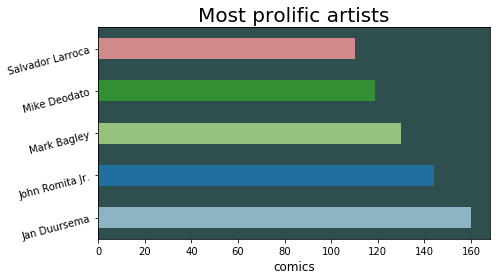

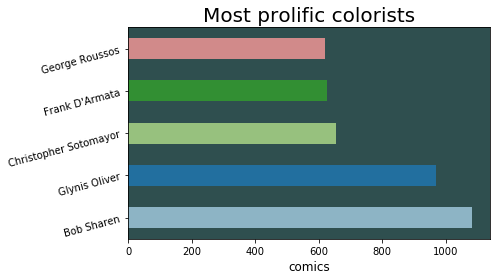

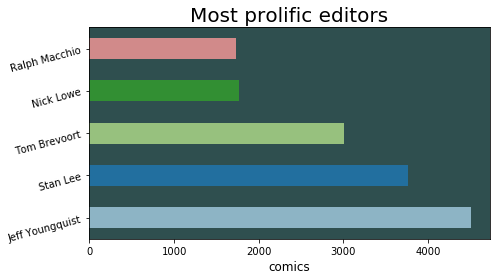

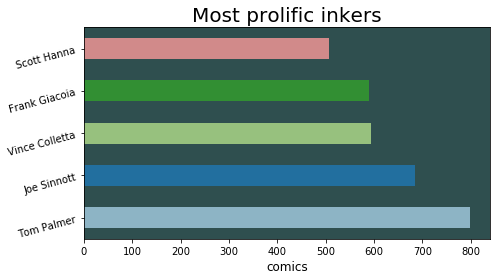

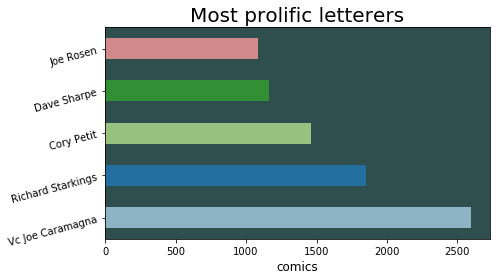

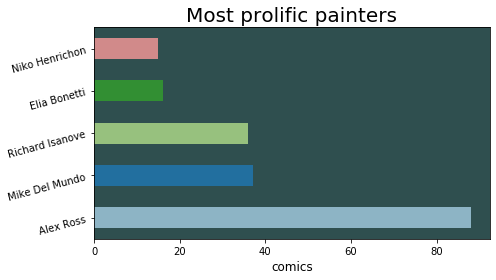

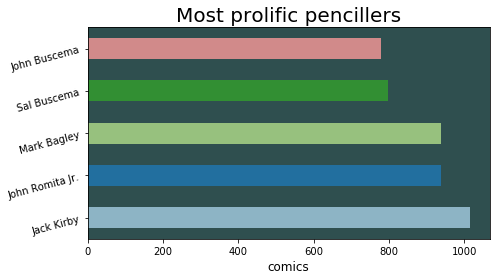

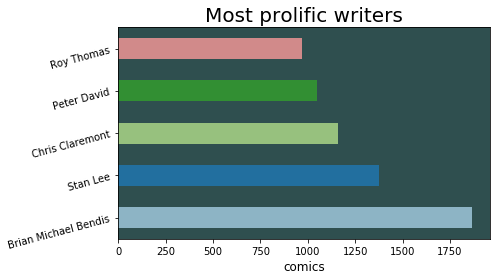

In [12]:
topics = "artist colorist editor inker letterer painter penciller writer".split()
for role in topics:
    most_prolific(df, role)

In [13]:
def plot_roles(df):
    roles = sorted("writer penciller painter other letterer inker editor colorist artist".split())
    values = df.loc[:, roles].sum().values
    data = {"comics": list(values)}
    roles_df = pd.DataFrame(data=data)
    roles_df.index = roles
    ax = roles_df.plot.barh(
        rot=15,
        figsize=(10,5),
        color=[plt.cm.Paired(np.arange(len(df)))],
        alpha=0.8,
        legend=False,
    )
    ax.set_title(f"Top roles in making comics", fontsize=20)
    ax.set_xlabel("comics", fontsize=12)
    ax.grid(False)
    ax.set_facecolor("darkslategray")
    plt.tight_layout()
    plt.show(block=True)
    fig = ax.get_figure()
    fig.savefig(f"{output_dir}/top_roles.png")

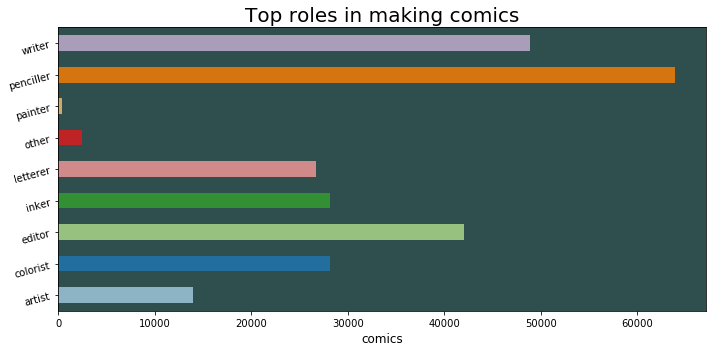

In [14]:
plot_roles(df)